# Урок 3. Generative adversarial networks (GAN): генеративные сети

ЗАДАНИЕ 1. 
Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * графики построить
 

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и сохранение ################################
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


Параметры для обучения обеих моделей

In [3]:
n_epochs = 1000

lr = 0.0002

b1 = 0.5
b2 = 0.999

latent_dim = 1

n_classes = 100
n_batchs=20
init_batch_size = n_classes*n_batchs
img_size = 1
channels = 1

sample_interval = 100

img_shape = (channels, img_size, img_size)

Генератор

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 2048),
            nn.Linear(2048, int(np.prod(img_shape))),
            nn.Tanh()
        )
#         self.activations = nn.ModuleDict([
#                 ['lrelu', nn.LeakyReLU()],
#                 ['relu', nn.ReLU()]])

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

Создание своих слоев

In [5]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

Дискриминатор

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

Инициализация

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = torch.nn.BCELoss()

d_loss_history = []
g_loss_history = []

In [8]:
x=np.linspace(1,500,n_classes)
for i in np.arange(n_batchs-1):
    x = np.append(x,np.linspace(1,500,n_classes))
def func_y(x):
    return np.sin(x)/x - x/10
print("Func_y:", func_y(x))    
#torch.from_numpy(func_y(x))

Func_y: [  0.74147098  -0.6438396   -1.19799932 ... -48.99226303 -49.49795456
 -50.00093554]


In [9]:
x

array([  1.        ,   6.04040404,  11.08080808, ..., 489.91919192,
       494.95959596, 500.        ])

In [10]:
real_data = torch.utils.data.DataLoader(    
    torch.tensor(list(zip(x,func_y(x)))),
    batch_size=init_batch_size,
    shuffle=True
)

In [11]:
#for i, (data) in enumerate(real_data):
#     imgs=data[:,0]  
#     print(imgs.shape)
#     print(imgs)
#     labels= data[:,1]
#     print(labels.shape)   
#     print(labels)
    

In [12]:
######## функция для вывода и сохранения изображения ########
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/1000] [Batch 0/1] [D loss: 0.693155] [G loss: 0.694901]


<Figure size 432x288 with 0 Axes>

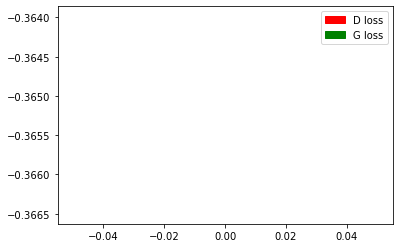

[Epoch 100/1000] [Batch 0/1] [D loss: 0.049621] [G loss: 3.036497]


<Figure size 432x288 with 0 Axes>

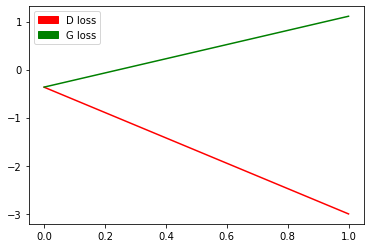

[Epoch 200/1000] [Batch 0/1] [D loss: 0.031527] [G loss: 4.473296]


<Figure size 432x288 with 0 Axes>

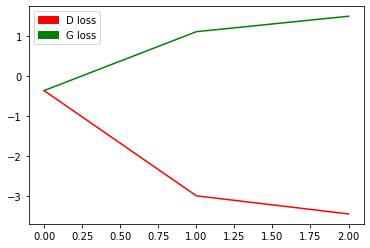

[Epoch 300/1000] [Batch 0/1] [D loss: 0.029890] [G loss: 4.544509]


<Figure size 432x288 with 0 Axes>

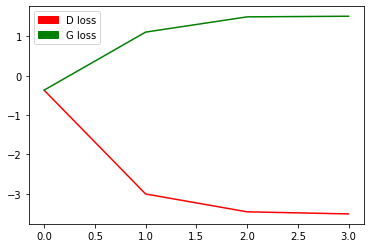

[Epoch 400/1000] [Batch 0/1] [D loss: 0.029177] [G loss: 4.585829]


<Figure size 432x288 with 0 Axes>

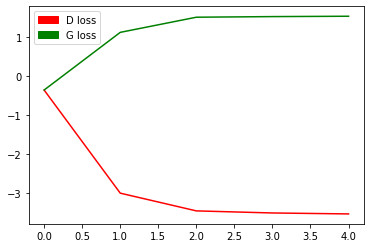

[Epoch 500/1000] [Batch 0/1] [D loss: 0.028794] [G loss: 4.593321]


<Figure size 432x288 with 0 Axes>

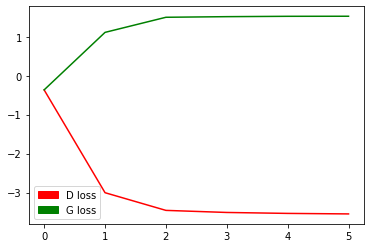

[Epoch 600/1000] [Batch 0/1] [D loss: 0.028560] [G loss: 4.598639]


<Figure size 432x288 with 0 Axes>

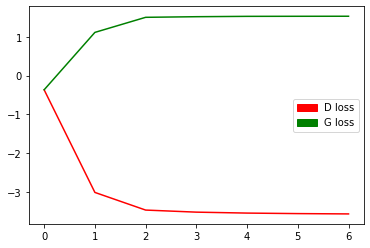

[Epoch 700/1000] [Batch 0/1] [D loss: 0.028410] [G loss: 4.602540]


<Figure size 432x288 with 0 Axes>

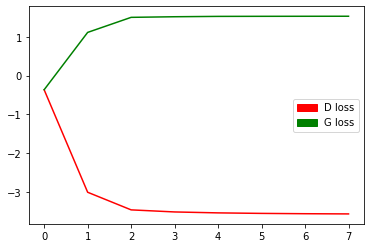

[Epoch 800/1000] [Batch 0/1] [D loss: 0.028313] [G loss: 4.605443]


<Figure size 432x288 with 0 Axes>

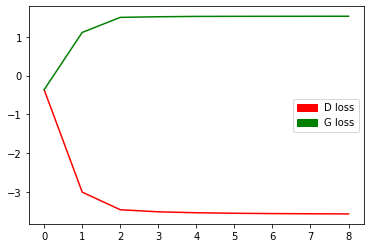

[Epoch 900/1000] [Batch 0/1] [D loss: 0.028247] [G loss: 4.607422]


<Figure size 432x288 with 0 Axes>

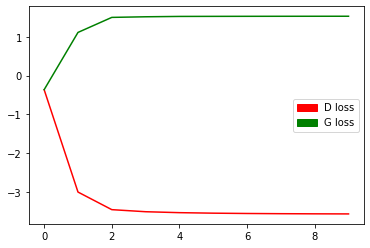

In [13]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        imgs=data[:,0]
        labels=data[:,1] 

        batch_size = init_batch_size#imgs.shape[0]
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_imgs = Variable(imgs.type(torch.FloatTensor)).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device)

        gen_imgs = generator(z)

        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            #display.clear_output(wait=False)
            #sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

            

In [14]:
torch.save(generator.state_dict(), "vanilla_gan2.pth")

In [15]:
d_loss

tensor(0.0282, grad_fn=<DivBackward0>)

In [16]:
g_loss

tensor(4.6090, grad_fn=<BinaryCrossEntropyBackward>)

ЗАДАНИЕ 2. Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [17]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch



In [88]:
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=2, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=300, help="interval between image sampling")
#opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
print(opt)

cuda = True if torch.cuda.is_available() else False

Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, img_size=32, latent_dim=100, lr=0.0002, n_cpu=8, n_epochs=2, sample_interval=300)


In [89]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity



In [90]:

# Loss function
adversarial_loss = torch.nn.BCELoss()

# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [91]:

def compute_gradient_penalty(D, X):
    """Calculates the gradient penalty loss for DRAGAN"""
    # Random weight term for interpolation
    alpha = Tensor(np.random.random(size=X.shape))

    interpolates = alpha * X + ((1 - alpha) * (X + 0.5 * X.std() * torch.rand(X.size())))
    interpolates = Variable(interpolates, requires_grad=True)

    d_interpolates = D(interpolates)

    fake = Variable(Tensor(X.shape[0], 1).fill_(1.0), requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty



In [92]:
d_loss_history = []
g_loss_history = []


[Epoch 0/2] [Batch 0/938] [D loss: 0.693353] [G loss: 0.677124]


<Figure size 432x288 with 0 Axes>

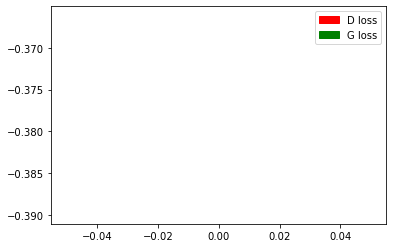

[Epoch 0/2] [Batch 300/938] [D loss: 13.982822] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

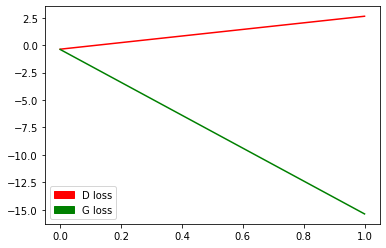

[Epoch 0/2] [Batch 600/938] [D loss: 14.411214] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

<ipython-input-93-d718074519d7>:66: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')


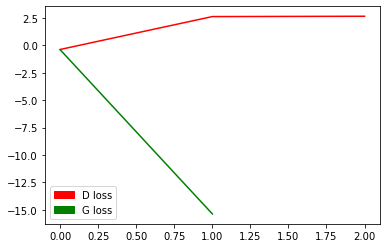

[Epoch 0/2] [Batch 900/938] [D loss: 14.649899] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

<ipython-input-93-d718074519d7>:66: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')


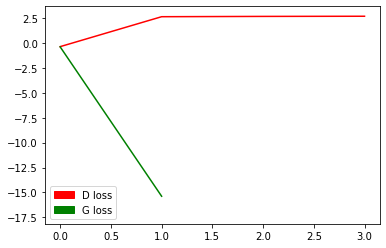

[Epoch 1/2] [Batch 262/938] [D loss: 14.832859] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

<ipython-input-93-d718074519d7>:66: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')


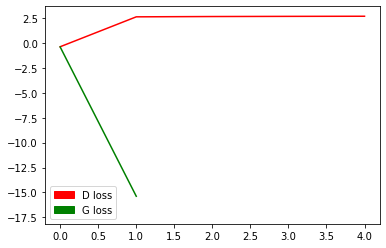

[Epoch 1/2] [Batch 562/938] [D loss: 14.914757] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

<ipython-input-93-d718074519d7>:66: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')


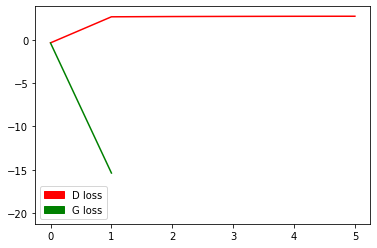

[Epoch 1/2] [Batch 862/938] [D loss: 15.017179] [G loss: 0.000000]


<Figure size 432x288 with 0 Axes>

<ipython-input-93-d718074519d7>:66: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')


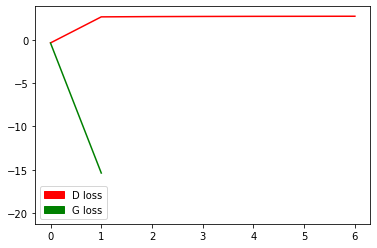

In [93]:

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(mnist_loader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Calculate gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data)
        gradient_penalty.backward()

        optimizer_D.step()
        
        
        batches_done = epoch * len(mnist_loader) + i 
        if batches_done % opt.sample_interval == 0:
            
            plt.clf()
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, opt.n_epochs, i, len(mnist_loader), d_loss.item(), g_loss.item()))            
            #display.clear_output(wait=False)
            #sample_image(gen_imgs)

            
            display.display(plt.gcf())

            d_loss_history.append(d_loss.item())
            g_loss_history.append(g_loss.item())

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

       
        

    save_image(gen_imgs.data, "images/%d.png" % epoch, nrow=int(math.sqrt(opt.batch_size)), normalize=True)

In [94]:
d_loss

tensor(14.5772, grad_fn=<DivBackward0>)

In [95]:
g_loss

tensor(0., grad_fn=<BinaryCrossEntropyBackward>)